# Projet 7 : Implémentez un modèle de scoring

# Partie 2 : Modélisation

Ce notebook de modélisation est organisé de la manière suivante :

* [**1. Prétraitement du jeu de données**](#1.-Prétraitement-du-jeu-de-données)
  * [**1.1 Import du jeu de données**](#1.1-Import-du-jeu-de-données)
  * [**1.2 Imputations, normalisation et standardisation**](#1.2-Imputations,-normalisation-et-standardisation)
  * [**1.3 Les métriques pour l'évaluation des performances des modèles de classification**](#1.3-Les-métriques-pour-l'évaluation-des-performances-des-modèles-de-classification)
  * [**1.4 La transformation des données déséquilibrées**](#1.4-La-transformation-des-données-déséquilibrées)
    * [**1.4.1 Transformation des données déséquilibrés par le sur-échantillonnage**](#1.4.1-Transformation-des-données-déséquilibrés-par-le-sur-échantillonnage)
      * [**1.4.1.1 Le sur-échantillonnage du jeu d'entrainement**](#1.4.1.1-Le-sur-échantillonnage-du-jeu-d'entrainement)
      * [**1.4.1.2 La validation croisée et les prédictions des modèles**](#1.4.1.2-La-validation-croisée-et-les-prédictions-des-modèles)
    * [**1.4.2 Transformation des données déséquilibrés par le sous-échantillonnage**](#1.4.2-Transformation-des-données-déséquilibrés-par-le-sous-échantillonnage)
      * [**1.4.2.1 Le sous-échantillonnage du jeu d'entrainement**](#1.4.2.1-Le-sous-échantillonnage-du-jeu-d'entrainement)
      * [**1.4.2.2 La validation croisée et les prédictions des modèles**](#1.4.2.2-La-validation-croisée-et-les-prédictions-des-modèles)
  * [**1.5 Feature importance**](#1.5-Feature-importance)
* [**2. Comparaison des différents modèles**](#2.-Comparaison-des-différents-modèles)
  * [**2.1 Comparaison des modèles par validation croisée**](#2.1-Comparaison-des-modèles-par-validation-croisée)
  * [**2.2 Sélection du modèle final**](#2.2-Sélection-du-modèle-final)
* [**3. La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation**](#3.-La-fonction-coût-métier,-l'algorithme-d'optimisation-et-la-métrique-d'évaluation)
  * [**3.1 La fonction coût métier et la métrique d'évaluation**](#3.1-La-fonction-coût-métier-et-la-métrique-d'évaluation)
  * [**3.2 L'algorithme d'optimisation**](#3.2-L'algorithme-d'optimisation)
  * [**3.3 Résultats de l’application de la fonction coût et de la métrique d’évaluation à l’algorithme d’optimisation**](#3.3-Résultats-de-l’application-de-la-fonction-coût-et-de-la-métrique-d’évaluation-à-l’algorithme-d’optimisation)
* [**4. L’interprétabilité globale et locale du modèle**](#4.-L’interprétabilité-globale-et-locale-du-modèle)
  * [**4.1 L'interprétabilité globale du modèle**](#4.1-L'interprétabilité-globale-du-modèle)
  * [**4.2 L'interprétabilité locale du modèle**](#4.2-L'interprétabilité-locale-du-modèle)
* [**5. Sérialisation des modèles**](#5.-Sérialisation-des-modèles)
  * [**5.1 Sérialisation de l'algorithme d'optimisation**](#5.1-Sérialisation-de-l'algorithme-d'optimisation)
  * [**5.2 Sérialisation des transformations (imputations, normalisation et standardisation)**](#5.2-Sérialisation-des-transformations-(imputations,-normalisation-et-standardisation))
* [**6. Conclusion**](#6.-Conclusion)

Nous commençons par importer les librairies nécessaires.

In [1]:
# Project 7: Implement a scoring model
# Part 2: Modelling
# Import libraries
import warnings
import pandas as pd
import seaborn as sns
%pylab inline
import timeit

# SHAP library
import shap

# Serialisation library
import pickle


from numpy import argmax
from collections import Counter

# Sickit-Learn library
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     cross_validate, cross_val_score,
                                     StratifiedKFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score,
                             auc, fbeta_score, roc_auc_score, roc_curve,
                             precision_recall_curve, plot_confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Imblearn library
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import (BalancedRandomForestClassifier,
                               RUSBoostClassifier)

# LightGBM library
from lightgbm import LGBMClassifier

# Hyperopt library
from hyperopt import Trials, fmin, hp, tpe

warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Functions
def feature_engineering(X_train, X_test, y_train, y_test, model,
                        report, global_feat_eng, feat_number, score):
    """This function displays the local or the global interpretability
    of a model and the classification metrics.
    """
    features = X_test.columns
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    # Cross-validation
    cv_results = cross_validate(model,
                                X_train,
                                y_train,
                                cv=StratifiedKFold(n_splits=5),
                                scoring=score,
                                return_train_score=True,
                                n_jobs=-1)
    
    # Training the model
    start_time = timeit.default_timer()
    clf = model.fit(X_train, y_train)
    
    # Making predictions
    y_pred = clf.predict(X_test)
    print("time: {:.2f}s".format(timeit.default_timer() - start_time))

    if report is True:
        # Evaluation of the model's performances on the test set
        # Metrics
        print(classification_report(y_test, y_pred))
        print("AUC: {:.2f}".format(
            roc_auc_score(y_test,
                          clf.predict_proba(X_test)[:, 1])))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        print("TPR: {:.2f}".format(tp / (tp + fn)))
        print("FPR: {:.2f}".format(fp / (fp + tn)))
        print("TNR: {:.2f}".format(tn / (tn + fp)))
        print("FNR: {:.2f}".format(fn / (fn + tp)))

        # Plot the Confusion matrix
        plt.style.use('default')
        fig, ax0 = plt.subplots(ncols=1, figsize=(3, 3))
        plot_confusion_matrix(clf, X_test, y_test, ax=ax0)
        ax0.set_title('Confusion matrix')
        plt.show()
    
    # Global and local interpretability of the model
    if global_feat_eng is True:
        # Displaying the Feature importance
        features_importance = clf.feature_importances_
        sorted_features = np.argsort(features_importance)
        features_df = pd.DataFrame(columns=['Feature', 'Importance value'])
        features_df['Feature'] = np.array(list(features))[sorted_features]
        features_df['Importance value'] = features_importance[sorted_features]
        features_df = features_df.sort_values(['Importance value'],
                                              ascending=False)
        relevant_features = list(features_df.Feature)
        features_df = features_df[features_df['Importance value'] > 0]

        # Plot
        # Setting up the figure
        plt.style.use('seaborn')
        fig = plt.figure(figsize=(25, 5))
        ax = sns.barplot(x='Feature', y='Importance value', data=features_df)
        fig = ax.get_figure()
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=90,
            ha='right')
        ax.set_title('Feature importance')
        ax.set_xlabel('Feature')
        ax.set_ylabel('Importance value')
        plt.show()
        return relevant_features
    else:
        # SHAP explanations
        shap.initjs()
        shap_explainer = shap.TreeExplainer(clf)
        shap_values = shap_explainer.shap_values(X_test)
        shap.summary_plot(shap_values,
                          X_test,
                          feature_names=features,
                          max_display=feat_number,
                          plot_type='bar',
                          plot_size=(5, 15))
        plt.show()


def classifiers_basic_comparison(X_train, X_test, y_train, y_test,
                                 classifiers, N_FOLDS):
    """This function evaluates the basic performances of classifiers
    in cross-validation using the classification metrics
    and the calculation time.
    """
    classifiers_names = []
    cv_auc =[]
    training_auc = []
    roc_auc = []
    precisions = []
    recalls = []
    score_f1 = []
    tprs = []
    fprs = []
    tnrs = []
    fnrs = []
    Fβ_score = []
    best_thr = []
    times = []
    for classifier in classifiers.keys():
        print("{}: ".format(classifier))
        
        # Instantiate the model
        model = classifiers[classifier]
        
        # Cross-validation
        start_time = timeit.default_timer()
        cv_results = cross_validate(model,
                                    X_train,
                                    y_train,
                                    cv=StratifiedKFold(n_splits=N_FOLDS),
                                    scoring='roc_auc',
                                    return_train_score=True,
                                    n_jobs=-1)
        
        # Training the model
        clf = model.fit(X_train, y_train)
        time = timeit.default_timer() - start_time
        
        # Making predictions
        y_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        
        # Evaluation of the model's performances on the test set
        # Metrics
        cv_auc.append(np.mean(cv_results['test_score']))
        training_auc.append(np.mean(cv_results['train_score']))
        roc_auc.append(roc_auc_score(y_test, y_proba))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tprs.append(tp / (tp + fn))
        fprs.append(fp / (fp + tn))
        tnrs.append(tn / (tn + fp))
        fnrs.append(fn / (fn + tp))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        score_f1.append(f1_score(y_test, y_pred))
        times.append(time)
        classifiers_names.append(classifier)
        
        # Get the Fβ score
        β = 3
        Fβ_score.append(fbeta_score(y_test, y_pred, beta=β))
        
        # Get the best threshold
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        fβscore = ((1 + β * β) * precision * recall) / (β * β * precision + recall)
        idx = argmax(fβscore)
        best_thresholds = thresholds[idx]
        best_thr.append(best_thresholds)
        
        # Plot the Confusion matrix
        plt.style.use('default')
        fig = plt.figure(figsize=(12, 5))
        ax = fig.add_subplot(121)
        plot_confusion_matrix(clf, X_test, y_test, ax=ax)
        ax.set_title('Confusion matrix')
        
        # Plot the ROC curve 
        fpr, tpr, thr = roc_curve(y_test, y_proba)
        auroc = auc(fpr, tpr)
        plt.style.use('seaborn')
        ax = fig.add_subplot(122)
        ax.plot(fpr, tpr, color='red', label='AUC={:.2f}'.format(auroc))
        ax.legend(loc='lower right')
        ax.plot([0, 1], [0, 1], linestyle='--')
        plt.axis('tight')
        plt.title('Receiver Operating Characteristic')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

    # Creation of the ranking dataframe
    classification = pd.DataFrame(
        columns=['Classifiers',
                 'Cross-validation AUC',
                 'Prediction AUC',
                 'Training AUC',
                 'Precision',
                 'Recall',
                 'F1 score',
                 'TPR',
                 'FPR',
                 'TNR',
                 'FNR',
                 'Fβ score',
                 'Best threshold',
                 'time (s)'])
    classification.Classifiers = classifiers_names
    classification['Cross-validation AUC'] = np.round(cv_auc, 2)
    classification['Prediction AUC'] = np.round(roc_auc, 2)
    classification['Training AUC'] = np.round(training_auc, 2)
    classification['Precision'] = np.round(precisions, 2)
    classification['Recall'] = np.round(recalls, 2)
    classification['F1 score'] = np.round(score_f1, 2)
    classification['TPR'] = np.round(tprs, 2)
    classification['FPR'] = np.round(fprs, 2)
    classification['TNR'] = np.round(tnrs, 2)
    classification['FNR'] = np.round(fnrs, 2)
    classification['Fβ score'] = np.round(Fβ_score, 2)
    classification['Best threshold'] = np.round(best_thr, 2)
    classification['time (s)'] = np.round(times, 2)
    classification = classification.set_index('Classifiers')
    classification = classification.sort_values(['Cross-validation AUC'],
                                                ascending=False)
    return classification


def classifiers_comparison(X_train, X_test, y_train, y_test,
                           classifiers, N_FOLDS):
    """This function evaluates the performances of optimised models
    in cross-validation using the classification metrics
    and the fit time.
    """
    classifiers_names = []
    training_auc = []
    cv_auc = []
    roc_auc = []
    precisions = []
    recalls = []
    score_f1 = []
    tprs = []
    fprs = []
    tnrs = []
    fnrs = []
    Fβ_score = []
    best_thr = []
    times = []
    params = []
    for classifier in classifiers.keys():
        classifiers_names.append(classifier)
        print("{}: ".format(classifier))
        
        # Instantiate the model
        model = classifiers[classifier][0]
        
        # Cross-validation
        # Parameters grid for optimisation
        param_grid = classifiers[classifier][1]
        
        # Score to optimise
        score = 'roc_auc'
        
        # Creating the grid search model
        model = GridSearchCV(
            # Pipeline for the given classifier
            model,
            # Hyperparameters to test
            param_grid,
            # Number of folds for the cross-validation
            cv=StratifiedKFold(n_splits=N_FOLDS),
            # Score to optimize
            scoring=score,
            # Number of jobs to run in parallel: using all processors
            n_jobs=-1)

        # Training the model
        clf = model.fit(X_train, y_train)
  
        # Classifier
        # Displaying the optimal hyperparameters
        best_params = clf.best_params_
        params.append(best_params)
        print(best_params)

        # Making predictions
        y_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
 
        # Evaluation of the model's performances on the test set
        # Metrics
        auroc = np.mean(clf.cv_results_['mean_test_score'])
        cv_auc.append(np.abs(auroc))
        roc_auc.append(roc_auc_score(y_test, y_proba))
        training_auc.append(model.score(X_train, y_train))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        tprs.append(tp / (tp + fn))
        fprs.append(fp / (fp + tn))
        tnrs.append(tn / (tn + fp))
        fnrs.append(fn / (fn + tp))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        score_f1.append(f1_score(y_test, y_pred))
        mean_fit_time = np.sum(clf.cv_results_['mean_fit_time'])
        times.append(mean_fit_time)

        # Get the Fβ score
        β = 3
        Fβ_score.append(fbeta_score(y_test, y_pred, beta=β))
        
        # Get the best threshold
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        fβscore = ((1 + β * β) * precision * recall) / (β * β * precision + recall)
        idx = argmax(fβscore)
        best_thresholds = thresholds[idx]
        best_thr.append(best_thresholds)
        
        # Plot the Confusion matrix
        plt.style.use('default')
        fig = plt.figure(figsize=(12, 5))
        ax = fig.add_subplot(121)
        plot_confusion_matrix(clf, X_test, y_test, ax=ax)
        ax.set_title('Confusion matrix')
        
        # Plot the ROC curve 
        fpr, tpr, thr = roc_curve(y_test, y_proba)
        auroc = auc(fpr, tpr)
        plt.style.use('seaborn')
        ax = fig.add_subplot(122)
        ax.plot(fpr, tpr, color='red', label='AUC={:.2f}'.format(auroc))
        ax.legend(loc='lower right')
        ax.plot([0, 1], [0, 1], linestyle='--')
        plt.axis('tight')
        plt.title('Receiver Operating Characteristic')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

    # Creating the ranking dataframe
    classification = pd.DataFrame(
        columns=['Classifiers',
                 'Cross-validation AUC',
                 'Prediction AUC',
                 'Training AUC',
                 'Precision',
                 'Recall',
                 'F1 score',
                 'TPR',
                 'FPR',
                 'TNR',
                 'FNR',
                 'Fβ score',
                 'Best threshold',
                 'fit-time (s)'])
    classification.Classifiers = classifiers_names
    classification['Cross-validation AUC'] = np.round(cv_auc, 2)
    classification['Prediction AUC'] = np.round(roc_auc, 2)
    classification['Training AUC'] = np.round(training_auc, 2)
    classification['Precision'] = np.round(precisions, 2)
    classification['Recall'] = np.round(recalls, 2)
    classification['F1 score'] = np.round(score_f1, 2)
    classification['TPR'] = np.round(tprs, 2)
    classification['FPR'] = np.round(fprs, 2)
    classification['TNR'] = np.round(tnrs, 2)
    classification['FNR'] = np.round(fnrs, 2)
    classification['Fβ score'] = np.round(Fβ_score, 2)
    classification['Best threshold'] = np.round(best_thr, 2)
    classification['fit-time (s)'] = np.round(times, 2)
    classification = classification.set_index('Classifiers')
    classification = classification.sort_values(['Cross-validation AUC'],
                                                ascending=False)
    return params, classification


def display_histogram(dataviz, ranking_var, sort, fig_size, color):
    """This function displays a histogram with the
    classifiers' comparison results using the metrics.
    """
    dataviz = dataviz.sort_values([ranking_var], ascending=sort)

    # Setting up the figure
    plt.style.use('seaborn')
    ax = dataviz.plot(kind='bar', figsize=fig_size, color=color)
    for value in ax.patches:
        ax.annotate(
            value.get_height(),
            (value.get_x() + value.get_width() / 2,
            value.get_height()),
            ha='center',
            va='bottom')
    fig = ax.get_figure()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title('Classification models ranking by {}'.format(ranking_var))
    ax.set_xlabel('Classifiers model')
    ax.set_ylabel('{}'.format(ranking_var))
    plt.show()

## 1. Prétraitement du jeu de données

### 1.1 Import du jeu de données

On charge ensuite le jeu de données.

In [3]:
# 1. Preprocessing
# 1.1 Loading the dataset
data = pd.read_csv('customers_df.csv', sep=',')

# Dimensions of the dataset
print(data.shape)
data.head()

(252137, 65)


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,...,PREV_AMT_DOWN_PAYMENT,PREV_AMT_CREDIT,PREV_RATE_DOWN_PAYMENT,PREV_CNT_PAYMENT,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,ORGANIZATION_TYPE
0,100002,1,0,1,1,0.0,202500.0,406597.5,24700.5,0.018801,...,0.00,179055.00,0.000000,24.000000,M,Working,Secondary / secondary special,Single / not married,House / apartment,Business Entity Type 3
1,100003,1,0,0,0,0.0,270000.0,1293502.5,35698.5,0.003541,...,3442.50,484191.00,0.050030,10.000000,F,State servant,Higher education,Married,House / apartment,School
2,100004,0,1,1,0,0.0,67500.0,135000.0,6750.0,0.010032,...,4860.00,20106.00,0.212008,4.000000,M,Working,Secondary / secondary special,Single / not married,House / apartment,Government
3,100006,1,0,1,0,0.0,135000.0,312682.5,29686.5,0.008019,...,34840.17,291695.50,0.163412,23.000000,F,Working,Secondary / secondary special,Civil marriage,House / apartment,Business Entity Type 3
4,100007,1,0,1,0,0.0,121500.0,513000.0,21865.5,0.028663,...,3390.75,166638.75,0.159516,20.666667,M,Working,Secondary / secondary special,Single / not married,House / apartment,Religion


In [4]:
# Data preprocessing
y = data.TARGET
X_df = data.drop(['TARGET', 'SK_ID_CURR'], axis=1)

# Feature selection
numeric_features = list(X_df.select_dtypes('int64').nunique().index)
numeric_features.extend(list(X_df.select_dtypes('float64').nunique().index))
cat_features = list(X_df.select_dtypes('object').nunique().index)

# Encoding the categorical features
X = pd.get_dummies(X_df, columns=cat_features)
df = X.nunique()
binary_features = list(df[df == 2].index)
num_features = list(df[df != 2].index)
print(X.shape)

# Split into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=y)

(252137, 141)


### 1.2 Imputations, normalisation et standardisation

In [5]:
# 1.2 Imputations, normalisation, and standardisation
# Preprocessing of the training set
# Imputations
num_imputer = SimpleImputer(missing_values=np.nan,
                            strategy='median')
Xtrain_num = pd.DataFrame(num_imputer.fit_transform(X_train[num_features]),
                          columns=num_features)

bin_imputer = SimpleImputer(missing_values=np.nan,
                            strategy='most_frequent')
Xtrain_bin = pd.DataFrame(bin_imputer.fit_transform(
    X_train[binary_features]), columns=binary_features)

# Normalisation
transformer = QuantileTransformer(output_distribution='normal',
                                  random_state=0)
Xtrain_norm = pd.DataFrame(transformer.fit_transform(
    Xtrain_num), columns=num_features)

# Standardisation
scaler = RobustScaler()
Xtrain_std = pd.DataFrame(scaler.fit_transform(Xtrain_norm),
                          columns=num_features)

for feature in binary_features:
    Xtrain_std[feature] = Xtrain_bin[feature]
print(Xtrain_std.shape)

(176495, 141)


In [6]:
# Preprocessing of the test set
# Imputations
Xtest_num = pd.DataFrame(num_imputer.transform(X_test[num_features]),
                         columns=num_features)
Xtest_bin = pd.DataFrame(bin_imputer.transform(X_test[binary_features]),
                         columns=binary_features)

# Normalisation
Xtest_norm = pd.DataFrame(transformer.transform(Xtest_num),
                          columns=num_features)

# Standardisation
X_test = pd.DataFrame(scaler.transform(Xtest_norm),
                      columns=num_features)

for feature in binary_features:
    X_test[feature] = Xtest_bin[feature]
print(X_test.shape)

(75642, 141)


### 1.3 Les métriques pour l'évaluation des performances des modèles de classification

Les métriques utilisées pour évaluer les performances des modèles sont :

- AUC : l'aire sous la courbe ROC (Receiver-Operator Characteristic) est un indicateur de la performance globale d'un modèle.
- Precision : la capacité d'un modèle à ne pas étiqueter comme positif un échantillon qui est négatif. La meilleure valeur est 1 et la pire valeur est 0. Plus le modèle prédit de faux positifs, plus la précision est faible.
- Recall : la capacité d'un modèle à retrouver tous les échantillons positifs. La meilleure valeur est 1 et la pire valeur est 0. Plus le modèle prédit de faux négatifs, plus le rappel est faible.
- F-beta score : la moyenne harmonique pondérée de la précision et du rappel définit l'influence de la précision ou du rappel sur l'évaluation. Le paramètre bêta détermine le poids de la précision ou du rappel dans le score combiné. La meilleure valeur est 1 et la pire valeur est 0. Pour notre étude, bêta vaut 3.
- Confusion matrix : une matrice qui montre le nombre de prédictions correctes et incorrectes faites par le modèle par rapport aux classifications réelles du jeu de test et qui permet de savoir les types d'erreurs (erreur de type I : les faux positifs, et erreur de type II : les faux négatifs).
- TP : nombre d’échantillons réellement positifs qui sont prédits positifs.
- TN : nombre d’échantillons réellement négatifs qui sont prédits négatifs.
- FP : nombre d’échantillons réellement négatifs mais qui sont prédits positifs.
- FN : nombre d’échantillons réellement positifs mais qui sont prédits négatifs.
- Accucracy : la proportion de points correctement prédits. C'est le rapport entre le nombre de prédictions correctes et le nombre total de prédictions.

Nous prenons également en compte le temps de calcul : time (s).

### 1.4 La transformation des données déséquilibrées

### 1.4.1 Transformation des données déséquilibrés par le sur-échantillonnage

#### 1.4.1.1 Le sur-échantillonnage du jeu d'entrainement

Nous appliquons l’Over-sampling au jeu de d’entrainement.

In [7]:
# 1.4 Transformation of imbalanced dataset
# 1.4.1 Transformation of imbalanced dataset by Over-sampling
# 1.4.1.1 Over-sampling the training set
smote = SMOTE(random_state=0, n_jobs=-1)
X_train_smote, y_train_smote = smote.fit_resample(Xtrain_std, y_train)
print('Original dataset samples per class: {}'.format(Counter(y_train)))
print('Resampled dataset samples per class: {}'.format(Counter(y_train_smote)))
print('Original dataset shape: {}'.format(y_train.shape))
print('Resample dataset shape: {}'.format(y_train_smote.shape))
print(X_train_smote.shape)

Original dataset samples per class: Counter({0: 161211, 1: 15284})
Resampled dataset samples per class: Counter({1: 161211, 0: 161211})
Original dataset shape: (176495,)
Resample dataset shape: (322422,)
(322422, 141)


#### 1.4.1.2 La validation croisée et les prédictions des modèles

Nous appliquons la validation croisée aux modèles à partir de leurs hyperparamètres de base et on effectue des prédictions sur le jeu de test.

In [8]:
# 1.4.1.2 Cross-validation and the predictions of models
classifiers_smote = {
    'Dummy Classifier (Baseline)': DummyClassifier(
        strategy='most_frequent', random_state=0),
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', random_state=0),
    'Balanced RandomForest': BalancedRandomForestClassifier(
        class_weight='balanced', random_state=0, n_jobs=-1),
    'LightGBM': LGBMClassifier(
        class_weight='balanced', random_state=0, n_jobs=-1)
}

Dummy Classifier (Baseline): 


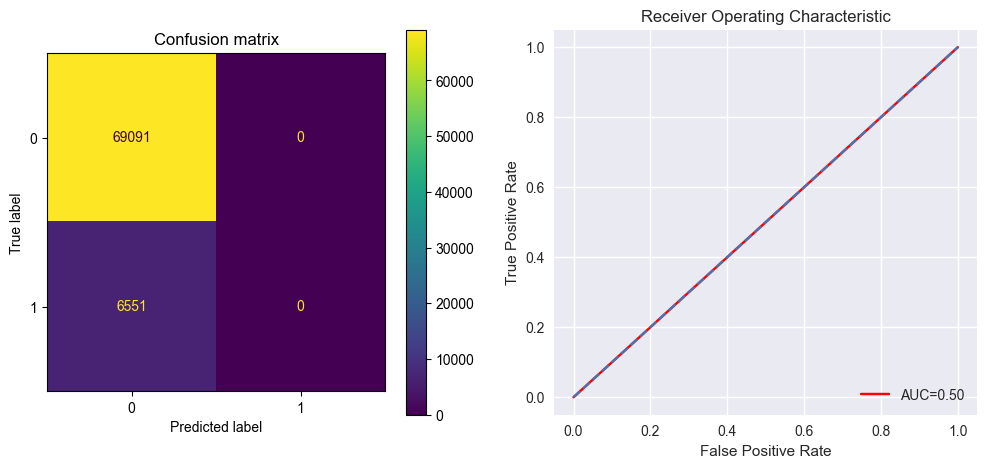

Logistic Regression: 


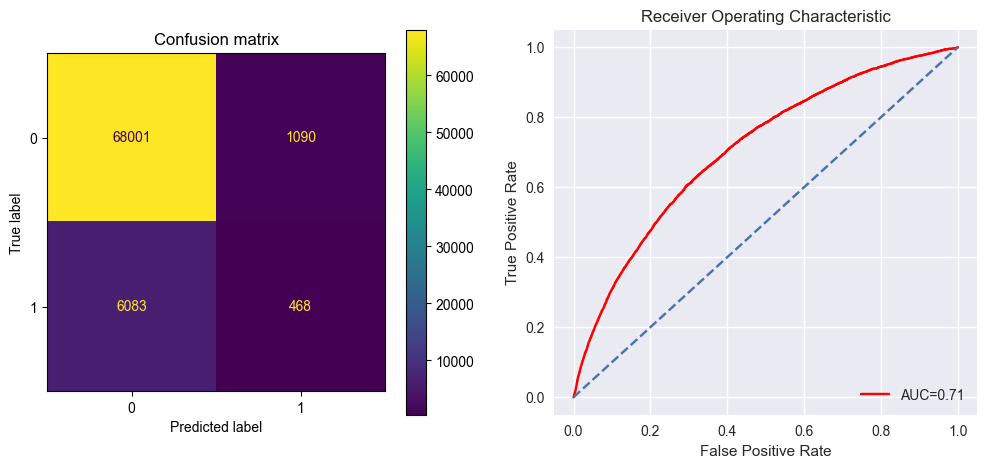

Balanced RandomForest: 


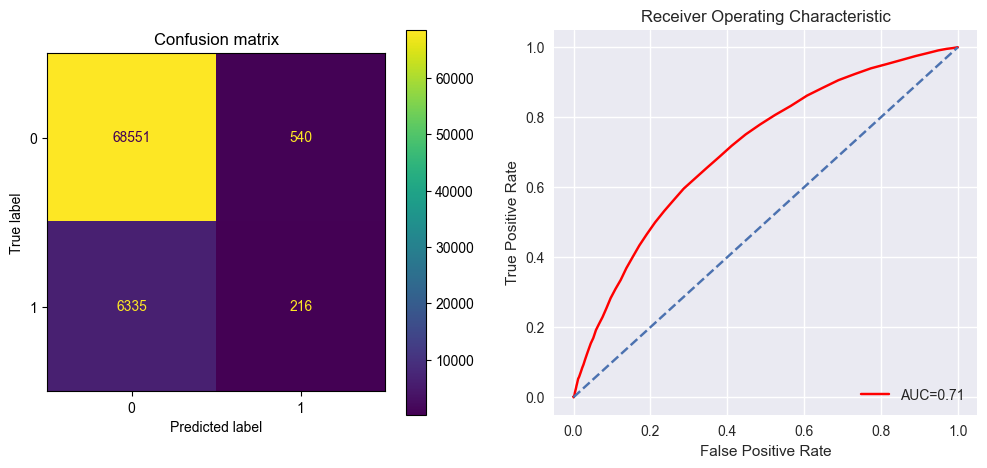

LightGBM: 


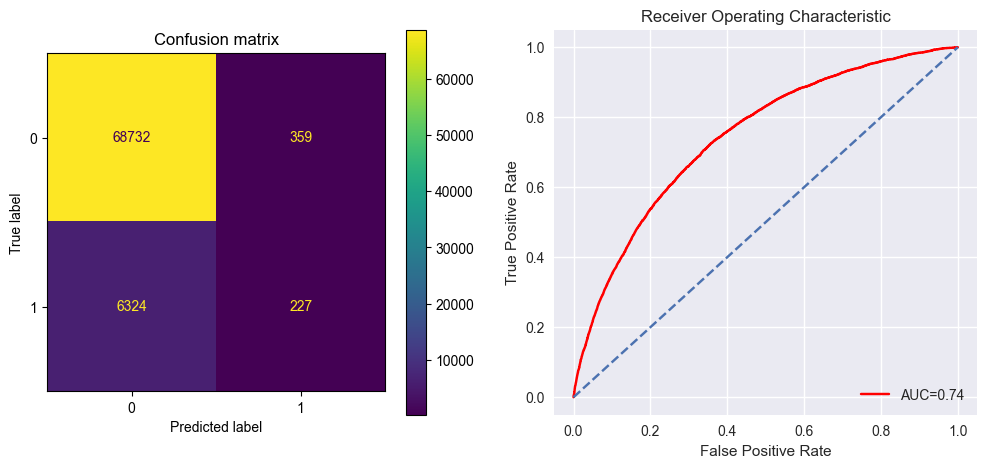

In [9]:
classification_smote = classifiers_basic_comparison(np.array(X_train_smote),
                                                    np.array(X_test),
                                                    y_train_smote,
                                                    y_test,
                                                    classifiers_smote,
                                                    5)

In [10]:
# Comparison of the basic performances of the classifiers
classification_smote

,Cross-validation AUC,Prediction AUC,Training AUC,Precision,Recall,F1 score,TPR,FPR,TNR,FNR,Fβ score,Best threshold,time (s)
Classifiers,,,,,,,,,,,,,
Balanced RandomForest,0.99,0.71,1.00,0.29,0.03,0.06,0.03,0.01,0.99,0.97,0.04,0.79,340.87
Logistic Regression,0.96,0.71,0.97,0.30,0.07,0.12,0.07,0.02,0.98,0.93,0.08,0.99,39.34
LightGBM,0.96,0.74,0.98,0.39,0.03,0.06,0.03,0.01,0.99,0.97,0.04,0.90,23.54
Dummy Classifier (Baseline),0.50,0.50,0.50,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,5.39


Les résultats de l’application du sur-échantillonnage sur le jeu d’entrainement sont :
- Les modèles sont en surapprentissage ;
- Les précisions sont meilleures que les rappels dont les valeurs sont proches de 0 ;
- Les taux des faux positifs sont quasiment nuls ;
- Les taux des faux négatifs sont très élevés avec des valeurs proches de 1.

L’Over-sampling permet de minimiser le nombre de faux positifs (l’erreur de type I). Étant donné que nous souhaitons plus pénaliser les faux négatifs (le nombre de crédits accordés par erreur aux clients ayant des risques élevés de défaut de paiement), l’Over-sampling n’est pas adaptée.

### 1.4.2 Transformation des données déséquilibrés par le sous-échantillonnage

#### 1.4.2.1 Le sous-échantillonnage du jeu d'entrainement

Nous appliquons l’Under-sampling au jeu de d’entrainement.

In [11]:
# 1.4.2 Transformation of imbalanced dataset by Under-sampling
# 1.4.2.1 Under-sampling the training set
rus = RandomUnderSampler(random_state=0)
X_train_res, y_train_res = rus.fit_resample(Xtrain_std, y_train)
print('Original dataset samples per class: {}'.format(Counter(y_train)))
print('Resampled dataset samples per class: {}'.format(Counter(y_train_res)))
print('Original dataset shape: {}'.format(y_train.shape))
print('Resample dataset shape: {}'.format(y_train_res.shape))
print(X_train_res.shape)

Original dataset samples per class: Counter({0: 161211, 1: 15284})
Resampled dataset samples per class: Counter({0: 15284, 1: 15284})
Original dataset shape: (176495,)
Resample dataset shape: (30568,)
(30568, 141)


#### 1.4.2.2 La validation croisée et les prédictions des modèles

Nous appliquons la validation croisée aux modèles à partir de leurs hyperparamètres de base et on effectue des prédictions sur le jeu de test.

In [12]:
# 1.4.2.2 Cross-validation and the predictions of models
classifiers = {
    'Dummy Classifier (Baseline)': DummyClassifier(
        strategy='most_frequent', random_state=0),
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', random_state=0),
    'RUSBoost': RUSBoostClassifier(random_state=0),
    'Balanced RandomForest': BalancedRandomForestClassifier(
        class_weight='balanced', random_state=0, n_jobs=-1),
    'LightGBM': LGBMClassifier(
        class_weight='balanced', random_state=0, n_jobs=-1)
}

Dummy Classifier (Baseline): 


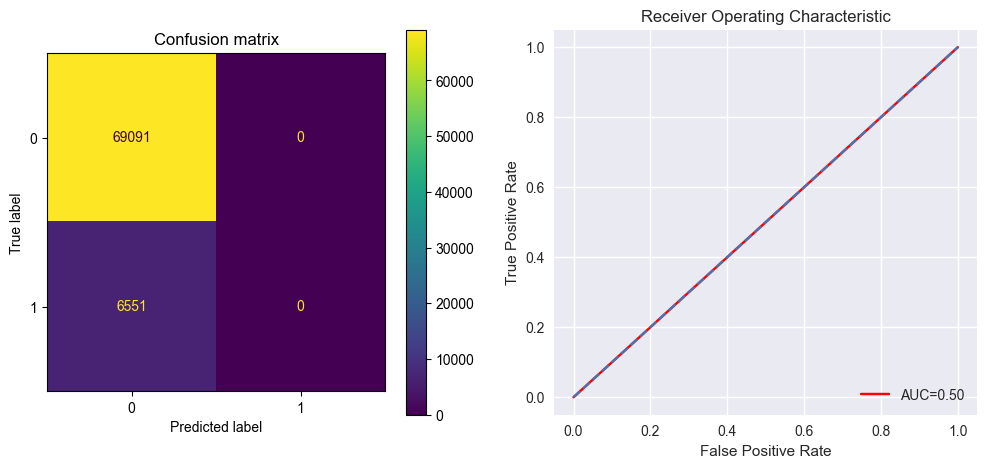

Logistic Regression: 


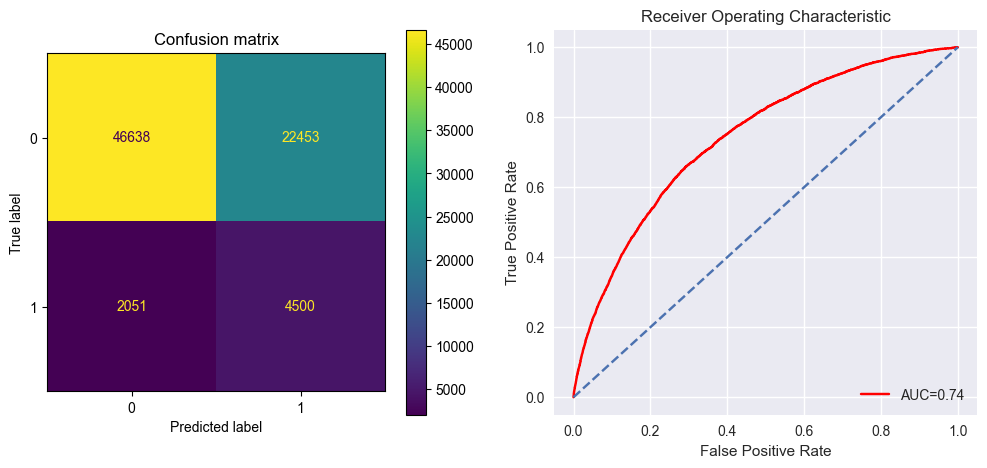

RUSBoost: 


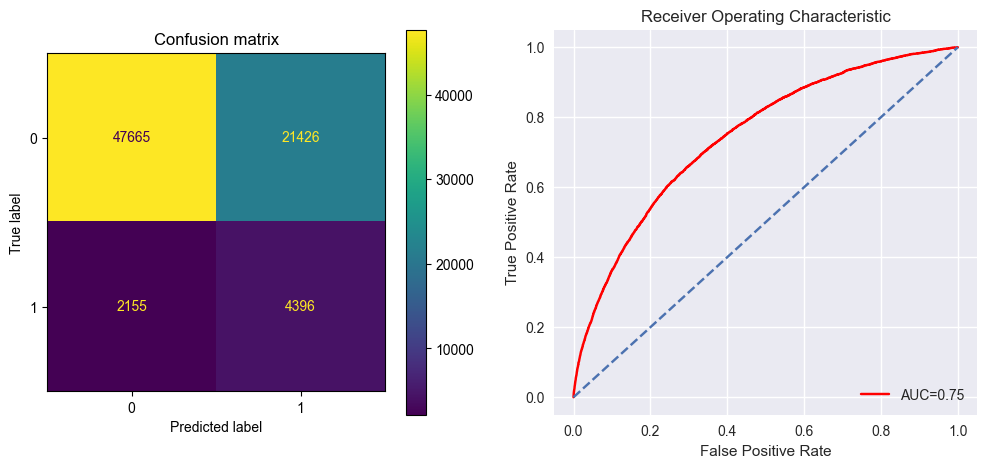

Balanced RandomForest: 


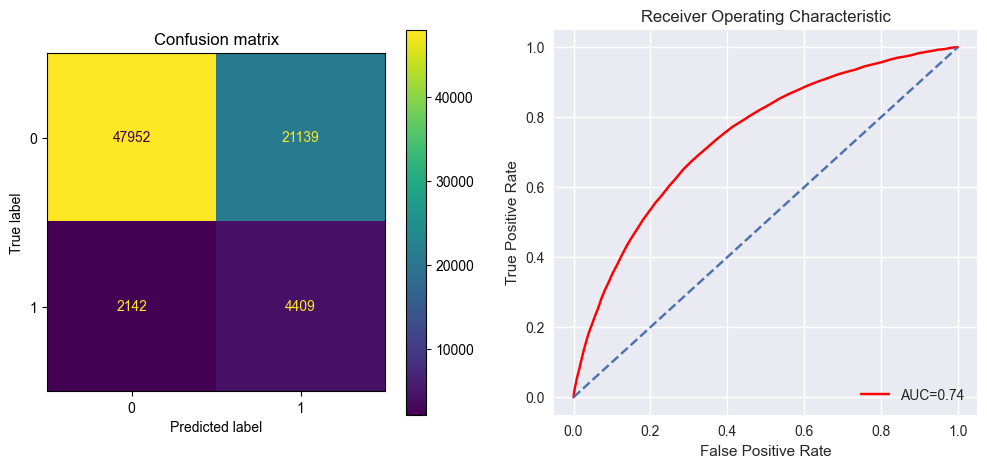

LightGBM: 


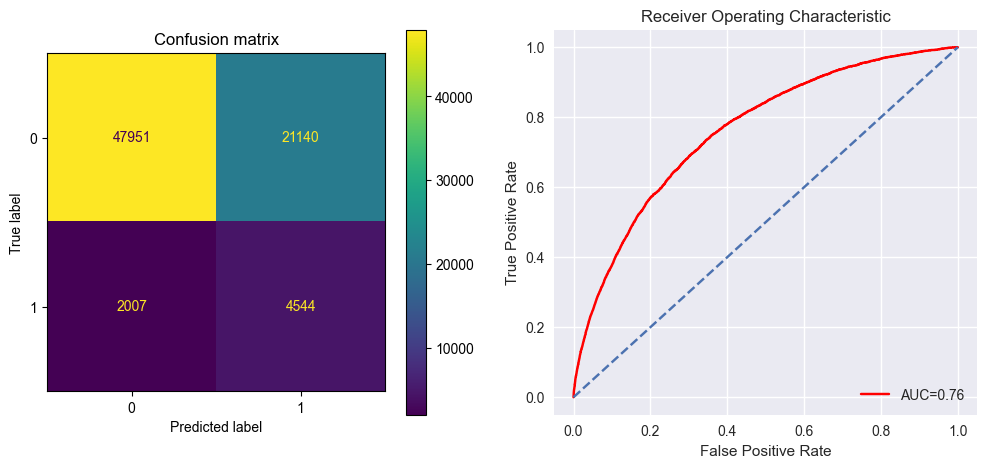

In [13]:
classification = classifiers_basic_comparison(np.array(X_train_res),
                                              np.array(X_test),
                                              y_train_res,
                                              y_test,
                                              classifiers,
                                              5)

In [14]:
# Comparison of the basic performances of the classifiers
classification

,Cross-validation AUC,Prediction AUC,Training AUC,Precision,Recall,F1 score,TPR,FPR,TNR,FNR,Fβ score,Best threshold,time (s)
Classifiers,,,,,,,,,,,,,
LightGBM,0.76,0.76,0.86,0.18,0.69,0.28,0.69,0.31,0.69,0.31,0.54,0.40,3.76
Logistic Regression,0.75,0.74,0.75,0.17,0.69,0.27,0.69,0.32,0.68,0.31,0.52,0.39,4.03
RUSBoost,0.75,0.75,0.76,0.17,0.67,0.27,0.67,0.31,0.69,0.33,0.52,0.50,25.27
Balanced RandomForest,0.74,0.74,1.00,0.17,0.67,0.27,0.67,0.31,0.69,0.33,0.52,0.41,15.91
Dummy Classifier (Baseline),0.50,0.50,0.50,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.96


Les résultats de l’application du sous-échantillonnage sur le jeu d’entrainement sont :
- Les modèles ne sont pas en surapprentissage ;
- Les rappels sont meilleurs que les précisions ;
- Les taux des faux positifs et des faux négatifs sont moins élevés et quasiment identiques.

L’Under-sampling permet de minimiser le nombre de faux négatifs (l’erreur de type II). Étant donné que nous souhaitons plus pénaliser les faux négatifs (le nombre de crédits accordés par erreur aux clients ayant des risques élevés de défaut de paiement), l’Under-sampling est plus adapté et permet d'entraîner les modèles sur des données réelles.

### 1.5 Feature importance

In [15]:
# 1.5 Feature importance
# Hyperparameters of the model
hyperparams = {
    # The number of trees in the forest
    'n_estimators': 300,
    # The function to measure the quality of a split
    'criterion': 'gini',
    # The maximum depth of the tree
    'max_depth': None,
    # The maximum depth of the tree
    'min_samples_split': 2,
    # The minimum number of samples required
    # to split an internal node
    'min_samples_leaf': 1,
    # Weights associated with classes in the form dictionary
    # with the key being the class_label and the value the weight
    'class_weight': 'balanced',
    # Control the randomisation of the algorithm
    'random_state': 0,
    # Number of CPU cores used during the cross-validation loop
    'n_jobs': -1
}
model = BalancedRandomForestClassifier(**hyperparams)

In [16]:
# Feature selection
selector = RFECV(
    estimator=model,
    step=1,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1)
selector = selector.fit(X_train_res, y_train_res)

In [17]:
ranking_df = pd.DataFrame({'Feature': list(X_train_res.columns)})
ranking_df['Rank'] = np.asarray(selector.ranking_)
ranking_df.sort_values('Rank', inplace=True)
relevant_features = ranking_df[ranking_df.Rank == 1]['Feature'].to_list()
print(len(relevant_features))
relevant_features

100


['CNT_CHILDREN',
 'NAME_HOUSING_TYPE_With parents',
 'NAME_HOUSING_TYPE_Rented apartment',
 'NAME_HOUSING_TYPE_Office apartment',
 'NAME_HOUSING_TYPE_Municipal apartment',
 'NAME_HOUSING_TYPE_House / apartment',
 'NAME_FAMILY_STATUS_Widow',
 'NAME_FAMILY_STATUS_Single / not married',
 'NAME_FAMILY_STATUS_Separated',
 'NAME_FAMILY_STATUS_Married',
 'NAME_FAMILY_STATUS_Civil marriage',
 'ORGANIZATION_TYPE_Agriculture',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_INCOME_TYPE_Working',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Commercial associate',
 'CODE_GENDER_M',
 'CODE_GENDER_F',
 'REG_CITY_NOT_WORK_CITY',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_REGION_NOT_WORK_REGION',
 'ORGANIZATION_TYPE_Transport: type 4',
 'REG_REGION_NOT_LIVE_REGION',
 'ORGANIZATION_TYPE_Bank',
 'ORGANIZATION_TYPE_Business Entity Type 2',
 'ORGANIZATION_TYPE_Transport: type 3',
 'ORGANIZATION_TYPE_Transport: t

In [18]:
# Transformation of the training set and the test set
X_train_rfe = selector.transform(X_train_res)
X_test_rfe = selector.transform(X_test)

time: 11.53s
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     69091
           1       0.17      0.68      0.28      6551

    accuracy                           0.69     75642
   macro avg       0.57      0.69      0.54     75642
weighted avg       0.89      0.69      0.76     75642

AUC: 0.75
TPR: 0.68
FPR: 0.31
TNR: 0.69
FNR: 0.32


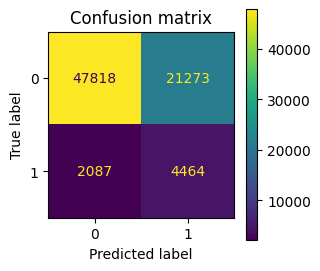

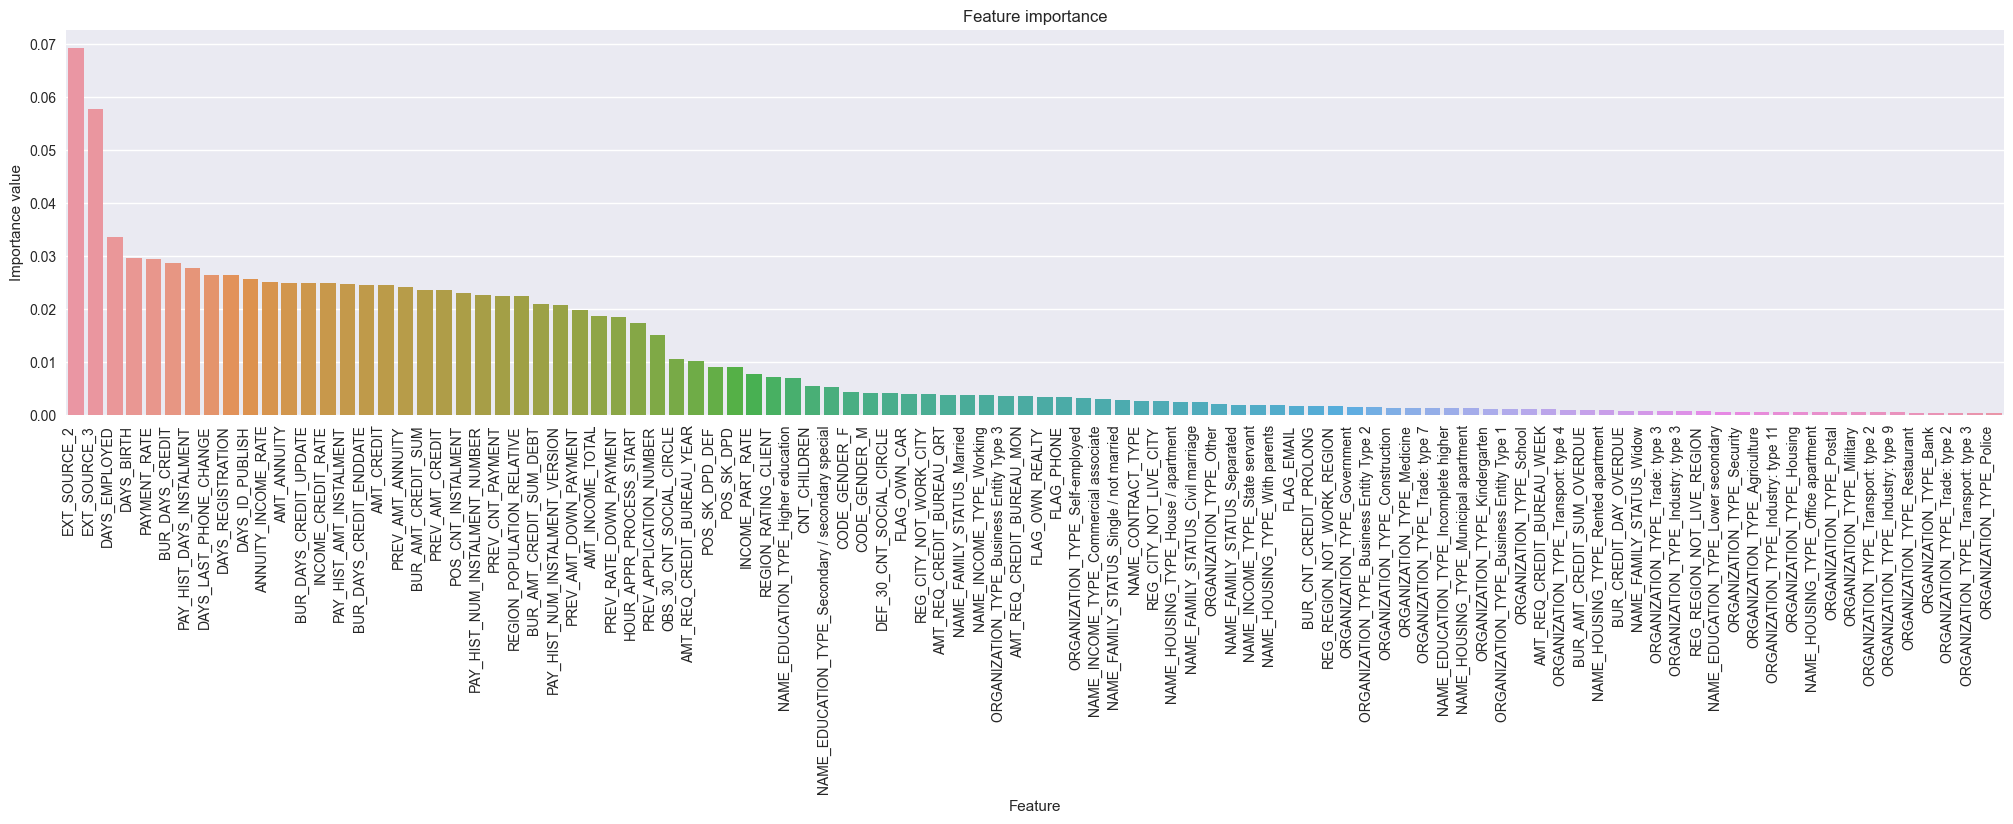

Number of relevant features: 100


In [19]:
# Global interpretability of the model
# Feature importance
features = feature_engineering(X_train_res[relevant_features],
                               X_test[relevant_features],
                               y_train_res,
                               y_test,
                               model,
                               True,
                               True,
                               None,
                               'roc_auc')
print("Number of relevant features: {}".format(len(features)))

## 2. Comparaison des différents modèles

Nous avons sélectionné les modèles suite au premier classement effectué à partir de leurs hyperparamètres de base. Nous allons ensuite effectuer le classement final en comparant les modèles les mieux classés par validation croisée. Cette comparaison est basée sur l'étude de la performance globale des modèles en analysant les scores AUC en validation croisée. On vérifie également le score de prédiction sur le jeu de test.

### 2.1 Comparaison des modèles par validation croisée

In [20]:
# 2. Comparison of the different models
# 2.1 Comparison of classifiers by the cross-validation
best_classifiers = {
    'LightGBM': [LGBMClassifier(),
        { 
          # Traditional Gradient Boosting Decision Tree
          'boosting_type': ['gbdt'],
          # Maximum tree leaves for base learners  
          'num_leaves': [15, 31],
          # Maximum tree depth for base learners 
          'max_depth': [-1, 6],
          # Learning rate shrinks the contribution of each tree
          'learning_rate': [0.05, 0.08, 0.1],
          # Number of boosted trees to fit
          'n_estimators': [100, 300],
          # Specify the learning task and the corresponding learning objective
          'objective': ['binary'],
          # Weights associated with classes in the form
          'class_weight': ['balanced'],
          # Subsample ratio of the training instance
          'subsample': [0.5, 1],
          # Subsample ratio of columns when constructing each tree
          'colsample_bytree': [1],
          # Random number seed
          'random_state': [0],
          # Number of parallel threads to use for training
          'n_jobs': [-1]
        }],
    'RUSBoost': [RUSBoostClassifier(),
        {
          # The base estimator from which the boosted ensemble is built
          # If None, the base estimator is DecisionTreeClassifier(max_depth=1)
          'base_estimator': [None],
          # The maximum number of estimators at which boosting is terminated
          'n_estimators': [100, 300],
          # Learning rate shrinks the contribution of each classifier
          'learning_rate': [0.1, 0.5, 0.6],
          # The boosting algorithm to use
          'algorithm': ['SAMME', 'SAMME.R'],
          # Whether or not to sample randomly with replacement or not
          'replacement': [False],
          # Control the randomisation of the algorithm
          'random_state': [0]
        }],
    'Logistic Regression': [LogisticRegression(),
        {
          # Specify the norm of the penalty
          'penalty': ['l2'],
          # Dual or primal formulation
          'dual': [False],
          # Inverse of regularisation strength; must be a positive float
          # Like in SVM, smaller values specify stronger regularisation
          'C': np.logspace(-3, 3, 3),
          # Specifies if a constant should be added to the decision function
          'fit_intercept': [True],
          # Weights associated with classes in the form
          'class_weight': ['balanced'],
          # Used when solver='sag', 'saga' or 'liblinear' to shuffle the data
          'random_state': [0],
          # Algorithm to use in the optimisation problem
          'solver': ['lbfgs', 'liblinear'],
          # Maximum number of iterations taken for the solvers to converge
          'max_iter': [100, 300],
          # Number of CPU cores used when parallelising over classes
          'n_jobs': [None]
        }]
}

LightGBM: 
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 300, 'n_jobs': -1, 'num_leaves': 15, 'objective': 'binary', 'random_state': 0, 'subsample': 0.5}


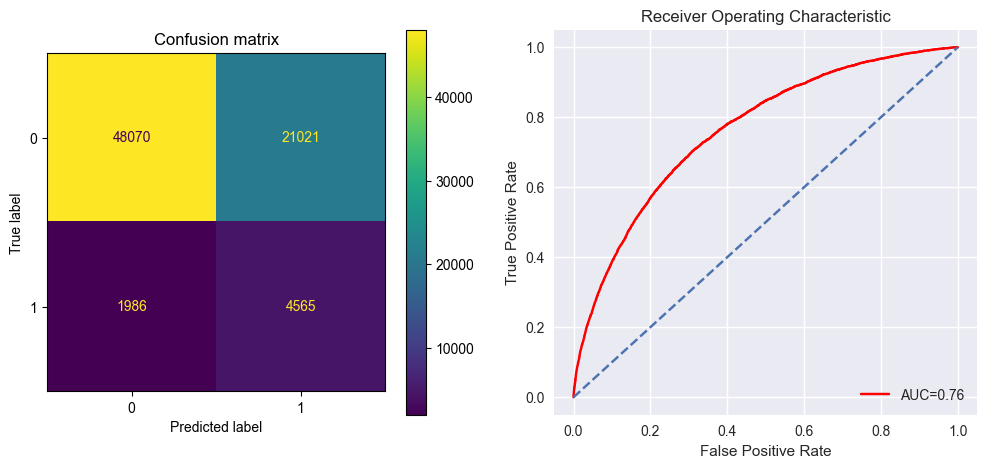

RUSBoost: 
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.5, 'n_estimators': 300, 'random_state': 0, 'replacement': False}


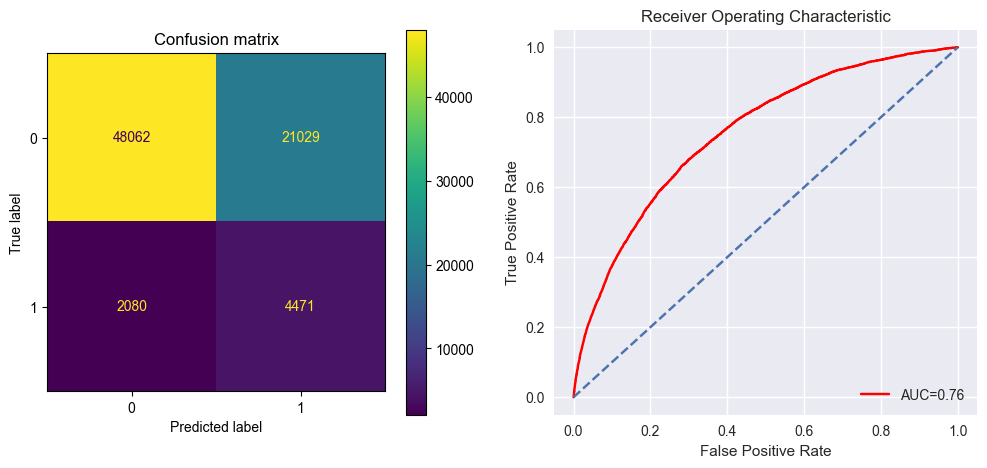

Logistic Regression: 
{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'max_iter': 300, 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs'}


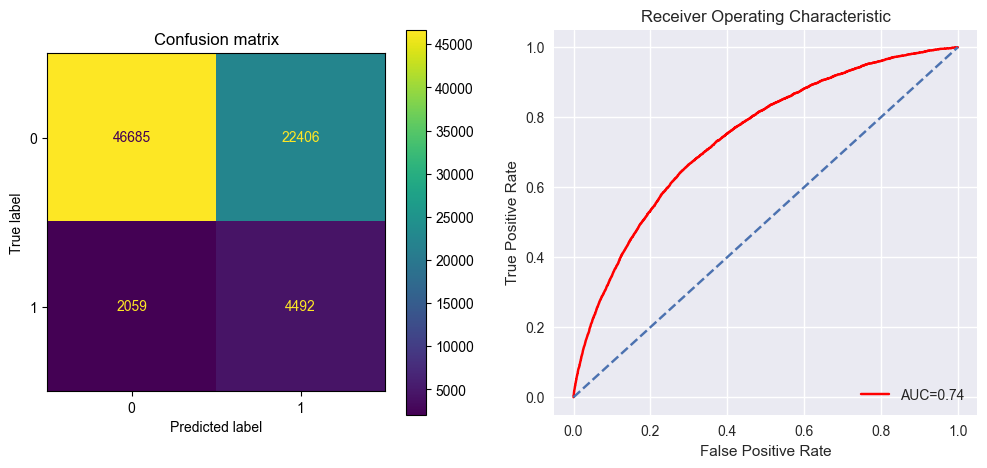

In [21]:
params, cv_classification = classifiers_comparison(X_train_rfe,
                                                   X_test_rfe,
                                                   y_train_res,
                                                   y_test,
                                                   best_classifiers,
                                                   5)

In [22]:
# Comparison of the performances of optimised classifiers
cv_classification

,Cross-validation AUC,Prediction AUC,Training AUC,Precision,Recall,F1 score,TPR,FPR,TNR,FNR,Fβ score,Best threshold,fit-time (s)
Classifiers,,,,,,,,,,,,,
LightGBM,0.76,0.76,0.82,0.18,0.70,0.28,0.70,0.30,0.70,0.30,0.54,0.37,119.13
RUSBoost,0.75,0.76,0.78,0.18,0.68,0.28,0.68,0.30,0.70,0.32,0.53,0.53,566.23
Logistic Regression,0.75,0.74,0.75,0.17,0.69,0.27,0.69,0.32,0.68,0.31,0.52,0.38,29.99


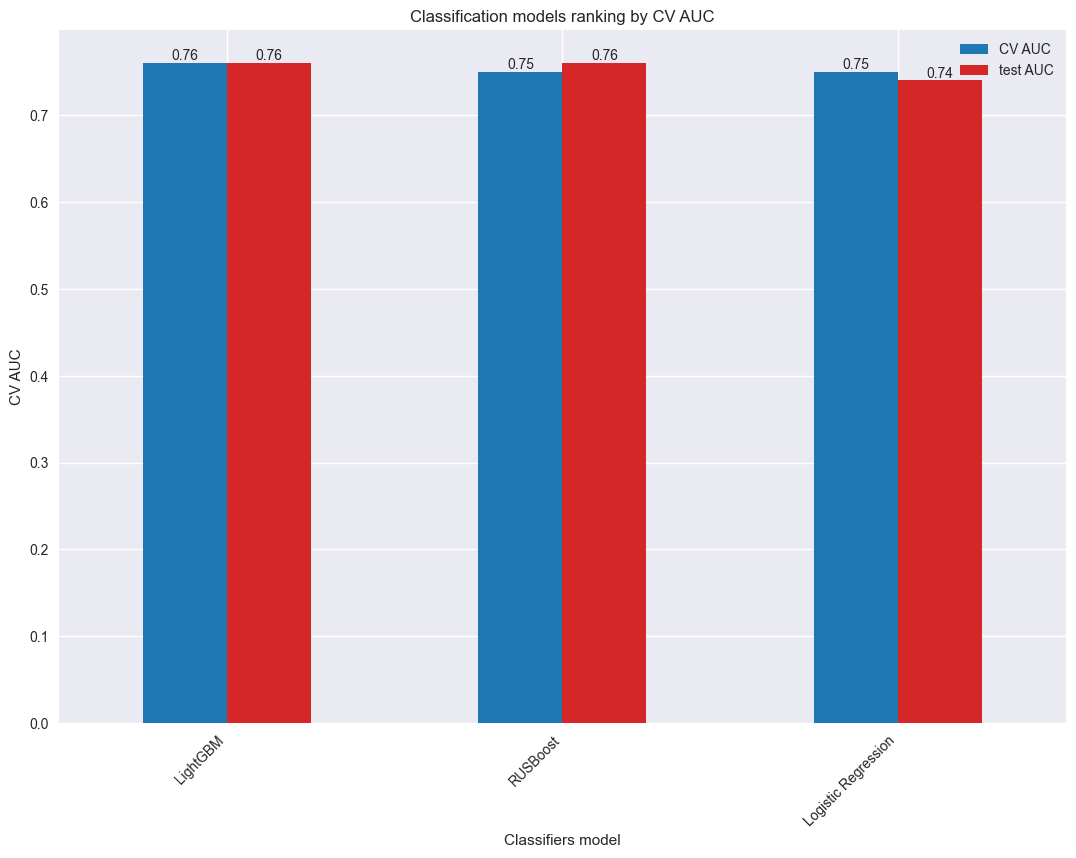

In [23]:
# Classifiers' ranking by the AUC score of the cross-validation
dataviz = cv_classification[['Cross-validation AUC', 'Prediction AUC']]
dataviz = dataviz.rename(columns={'Cross-validation AUC': 'CV AUC',
                        'Prediction AUC': 'test AUC'})
display_histogram(
    dataviz, 'CV AUC', False, (13, 9), ['tab:blue', 'tab:red'])

En comparant les scores AUC des différents modèles en validation croisée, l’algorithme de classification LigthGBM est le modèle le mieux classé. De plus, le score AUC sur le jeu de test est identique au score AUC en validation croisée.

### 2.2 Sélection du modèle final

Le modèle final sélectionné est le LightGBM, un framework du gradient boosting :
- Rapide (utilisation réduite de la mémoire) ; 
- Efficace (une meilleure précision) ;
- Optimisé (prise en charge de l'apprentissage parallèle, distribué sur GPU et capable de traiter de grande taille de données).

time: 1.35s
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     69091
           1       0.18      0.70      0.28      6551

    accuracy                           0.70     75642
   macro avg       0.57      0.70      0.55     75642
weighted avg       0.89      0.70      0.76     75642

AUC: 0.76
TPR: 0.70
FPR: 0.30
TNR: 0.70
FNR: 0.30


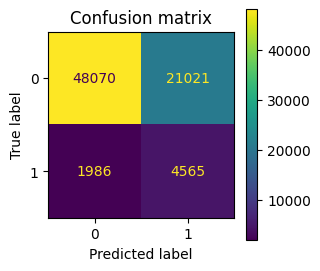

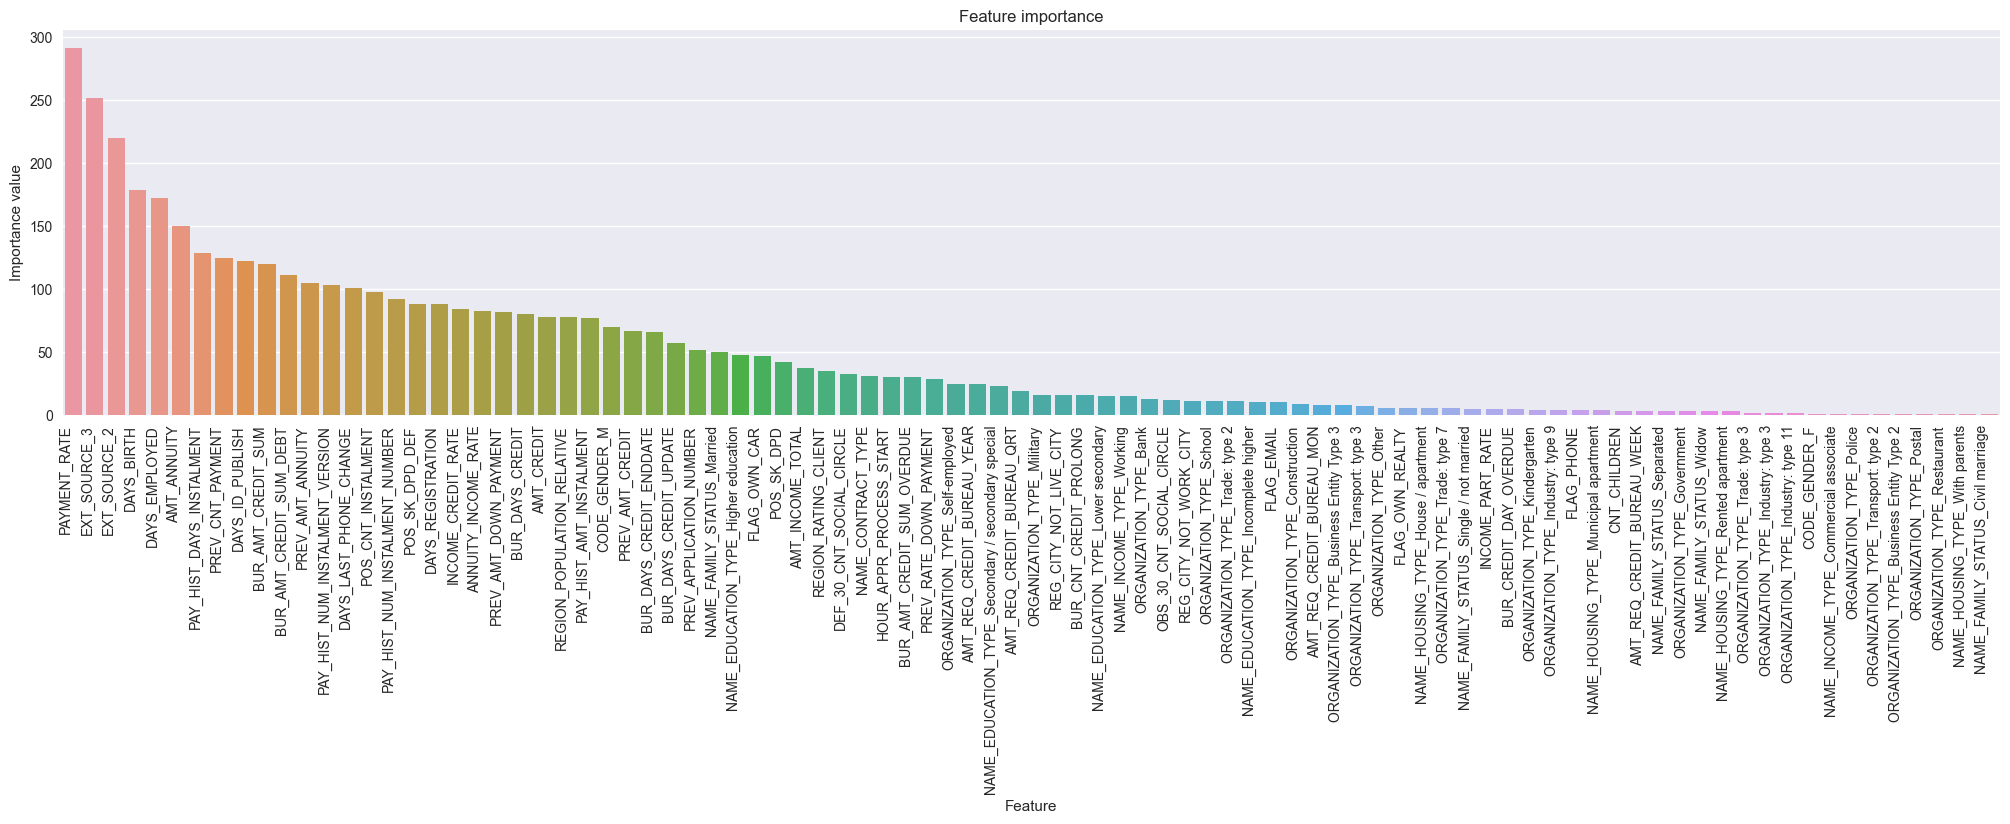

Number of relevant features: 100


In [24]:
# 2.2 Selection of the final model
# Global and local interpretability of the model
hyperparams = {
    'boosting_type': params[0]['boosting_type'],
    'num_leaves': params[0]['num_leaves'],
    'max_depth': params[0]['max_depth'],
    'learning_rate': params[0]['learning_rate'],
    'n_estimators': params[0]['n_estimators'],
    'objective': params[0]['objective'],
    'class_weight': params[0]['class_weight'],
    'subsample': params[0]['subsample'],
    'colsample_bytree': params[0]['colsample_bytree'],
    'random_state': params[0]['random_state'],
    'n_jobs': params[0]['n_jobs']
}
classifier = LGBMClassifier(**hyperparams)

# Global interpretability of the model
# Feature importance
features = feature_engineering(X_train_res[relevant_features],
                               X_test[relevant_features],
                               y_train_res,
                               y_test,
                               classifier,
                               True,
                               True,
                               None,
                               'roc_auc')
print("Number of relevant features: {}".format(len(features)))

On observe que :
- Le score du modèle en prédiction est identique au score en validation croisée ;
- Le rappel est identique pour les deux classes avec une valeur de 0,7 proche de 1 ;
- La précision est élevée pour la classe 0 (0,96) mais faible pour la classe 1 (0,18).

time: 1.30s


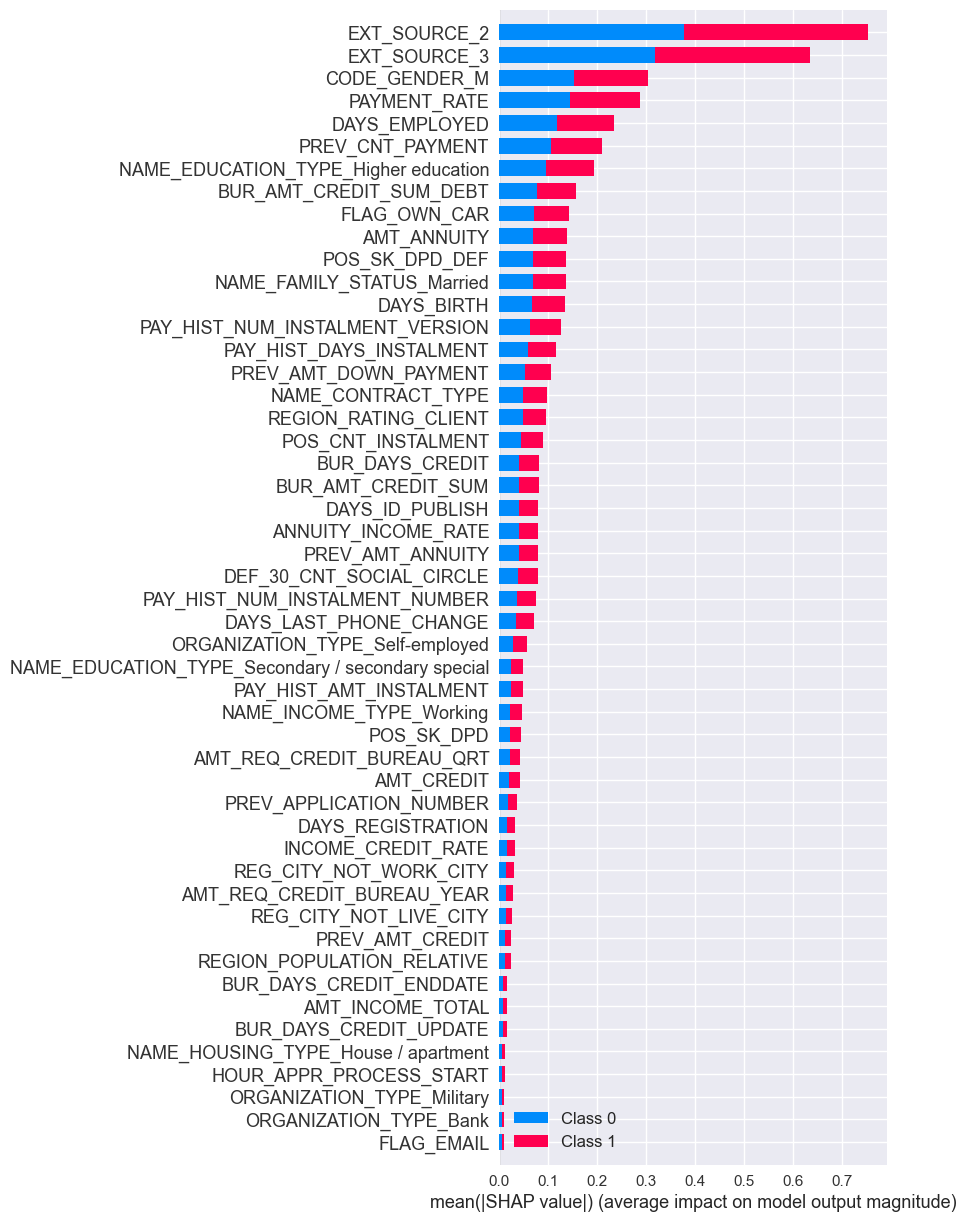

In [25]:
# Local interpretability of the model
# SHAP explanations
feature_engineering(X_train_res[relevant_features],
                    X_test[relevant_features],
                    y_train_res,
                    y_test,
                    classifier,
                    False,
                    False,
                    50,
                    'roc_auc')

## 3. La fonction coût métier, l'algorithme d'optimisation et la métrique d'évaluation

### 3.1 La fonction coût métier et la métrique d'évaluation

La fonction coût est une estimation du gain financier ou de perte financière pour l’entreprise. Il s’agit d’une problématique métier et l’objectif est de minimiser :
- Le nombre de clients ayant des situations sans risque de défaut de paiement dont les demandes de crédits sont refusées par erreur (l’erreur de type I ou les faux positifs) ;
- Le nombre de crédits accordés par erreur aux clients ayant des risques élevés de défaut de paiement (l’erreur de type II ou les faux négatifs).

Pour atteindre cet objectif, il faut :
- Maximiser le rappel et la précision ;
- Minimiser le taux de faux positifs (FPR) et le taux de faux négatifs (FNR).

Le rappel, la précision, le FPR et le FNR sont calculés de la manière suivante :
$$
recall = \frac{TP}{TP+FN}
$$
$$
precision = \frac{TP}{TP+FP}
$$
$$
FPR = \frac{FP}{TN+FP}
$$
$$
FPR = \frac{FN}{TP+FN}
$$

La matrice de confusion permet d’avoir le nombre de :
- Vrais positifs TP : nombre d’échantillons réellement positifs qui sont prédits positifs ;
- Vrais négatifs TN : nombre d’échantillons réellement négatifs qui sont prédits négatifs ;
- Faux positifs FP : nombre d’échantillons réellement négatifs mais qui sont prédits positifs ;
- Faux négatifs FN : nombre d’échantillons réellement positifs mais qui sont prédits négatifs.

La métrique d’évaluation est le "credit score", une fonction perte calculée à partir du F-beta score :
$$
F_{β}=(1+β^2) \cdot \frac{precision \cdot recall}{β^2 \cdot precision+recall}
$$
$$
credit \ score=1-F_{β}
$$

L’enjeu ici est de trouver le bon compromis entre le rappel et la précision et cela dépend du choix de la valeur de β :
- Si β < 1, la précision a plus de poids dans l’évaluation (on pénalise plus les faux positifs) ;
- Si β = 1, la précision et le rappel ont un des poids identiques dans l’évaluation (on obtient dans ce cas le F1 score) ;
- Si β > 1, le rappel a plus de poids dans l’évaluation (on pénalise plus les faux négatifs).

Nous avons sélectionné, la valeur de β égale à 3 pour donner plus de poids au rappel afin de plus pénaliser les faux négatifs par rapport aux faux positifs.

Pour déterminer la classe (0 ou 1) d’un client, un seuil de décision est déduit à partir de la courbe de précision et rappel. La valeur calculée vaut 0,36.

In [26]:
# 3. The business cost function, the optimisation algorithm,
# and the metric of evaluation
# 3.1 The business cost function and the metric of evaluation
# Functions
def credit_score(model, X, y, β=3):
    """This function uses the credit_score and the loss score
    to penalize the FNR and the FPR.
    """
    y_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_proba)
    fβscore = ((1 + β * β) * precision * recall) / (β * β * precision + recall)
    idx = argmax(fβscore)
    best_threshold = thresholds[idx]
    y_pred = np.where(y_proba > best_threshold, 1, 0)
    fβ_score = fbeta_score(y, y_pred, beta=β)
    credit_score = 1 - fβ_score
    return credit_score


def scores_analysis(model, X_test, y_test, β):
    """This function calculates Fβ and Credit scores
    according to the best threshold and displays visualisations.
    """
    # Making predictions
    y_proba =  model.predict_proba(X_test)[:, 1]
    
    # Get the best threshold
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    fβscore = ((1 + β * β) * precision * recall) / (β * β * precision + recall)
    idx = argmax(fβscore)
    best_threshold = thresholds[idx]
    
    # Fβ and Credit scores calculation
    y_pred = np.where(y_proba > best_threshold, 1, 0)
    counter = Counter(y_pred)
    Fβ_score = fbeta_score(y_test, y_pred, beta=β)
    Credit_score = 1 - Fβ_score
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Displaying the results
    print('\nFβ score: {:.2f}'.format(Fβ_score))
    print('Credit score: {:.2f}'.format(Credit_score))
    print('\nBest threshold: {:.2f}'.format(best_threshold))
    print("Class 0: {}".format(counter[0]))
    print("Class 1: {}".format(counter[1]))
    print("\nTP: {}".format(tp))
    print("TN: {}".format(tn))
    print("FP: {}".format(fp))
    print("FN: {}".format(fn))
    print("\nTPR: {:.2f}".format(tp / (tp + fn)))
    print("TNR: {:.2f}".format(tn / (tn + fp)))
    print("FPR: {:.2f}".format(fp / (fp + tn)))
    print("FNR: {:.2f}".format(fn / (fn + tp)))
    
    # Plots
    # Precision Recall curve
    plt.style.use('seaborn')
    plt.plot(recall, precision, color='green')
    plt.axis('tight')
    plt.title('Precision Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

    probas = np.linspace(0, 1, num=11)
    credit_score = []
    fβ_score = []
    fnrs = []
    fprs =[]
    for proba in probas:
        y_pred = np.where(y_proba >= proba, 1, 0)
        fβ_score.append(fbeta_score(y_test, y_pred, beta=β))
        credit_score.append(1-fbeta_score(y_test, y_pred, beta=β))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fnrs.append(fn / (fn + tp))
        fprs.append(fp / (fp + tn))
    
    plt.plot(probas, fβ_score,
             'o-', color='tab:blue', label='fβ score')
    plt.plot(probas, credit_score,
             'o-', color='tab:red', label='credit score')
    plt.plot(probas, fnrs,
             'o-', color='tab:green', label='false negative rate')
    plt.plot(probas, fprs,
             'o-', color='tab:purple', label='false positive rate')
    plt.legend(loc='center right')
    plt.title('fβ_score, credit_score, FNR and FPR curves')
    plt.xlabel('class probabilities')
    plt.ylabel('fβ_score, credit_score, FNR, FPR')
    plt.xticks(rotation=0)
    plt.show()
    

def best_params_search(space):
    """This function applies the cross-validation by using
    Hyperopt to find the best parameters of a model.
    """
    params = {
        'num_leaves': int(space['num_leaves']),
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'n_estimators': int(space['n_estimators']),
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'min_child_weight': space['min_child_weight'],
        'min_child_samples': int(space['min_child_samples'])
    }
    model = LGBMClassifier(**params)
    score = cross_val_score(model,
                            np.array(X_train_res),
                            y_train_res,
                            cv=StratifiedKFold(n_splits=5),
                            scoring=credit_score,
                            error_score='raise',
                            n_jobs=-1).mean()
    return score

### 3.2 L'algorithme d'optimisation

L’algorithme du LightGBM est utilisé. La recherche des hyperparamètres optimaux du modèle est effectuée par une validation croisée. La métrique d’optimisation est le "credit score".

In [27]:
# 3.2 Algorithm of optimisation
β = 3
param_grid = {
    'num_leaves': hp.uniform('num_leaves', 10, 30),
    'max_depth': hp.uniform('max_depth', -1, 7),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'n_estimators': hp.uniform('n_estimators', 100, 500),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0, 1),
    'min_child_samples': hp.uniform('min_child_samples', 10, 20)
}

# Searching the best hyperparameters
best = fmin(
    # Function to optimise
    fn=best_params_search,
    # Parametrs
    space=param_grid,
    # Algorithm of optimisation
    # Hyperopt select its parameters automatically
    algo=tpe.suggest,
    # Maximum number of iterations
    max_evals=25,
    # Random generator seed
    rstate=np.random.seed(0),
    # Trials contains logging information
    trials=Trials()
)
print(best)

100%|███████████████████████████████████████████████| 25/25 [01:02<00:00,  2.50s/trial, best loss: 0.08976223249967392]
{'colsample_bytree': 0.17684709345642513, 'learning_rate': 0.10551747126979868, 'max_depth': 0.7333815510651291, 'min_child_samples': 16.055433475024916, 'min_child_weight': 0.8251808027019946, 'n_estimators': 181.40149220672757, 'num_leaves': 27.19385690607738, 'reg_alpha': 0.8599850014580219, 'reg_lambda': 0.23434588561380887, 'subsample': 0.3965924082932183}


HyperOpt fournit plusieurs combinaisons d'hyperparamètres possibles. Les hyperparamètres ci-dessous sont appliqués au modèle :

100%|███████████████████████████████████████████████| 25/25 [01:14<00:00,  2.97s/trial, best loss: 0.08985620632309474]
{'colsample_bytree': 0.3301667763666091, 'learning_rate': 0.09523910339979674, 'max_depth': -0.8623028138372382, 'min_child_samples': 12.509705006649861, 'min_child_weight': 0.00699789407102781, 'n_estimators': 491.5617365996512, 'num_leaves': 10.031923423311687, 'reg_alpha': 0.27768383622991344, 'reg_lambda': 0.4718921503361463, 'subsample': 0.875316109294948}

In [28]:
# Applying the optimal hyperparameters to the model
hyperparams = {
    'boosting_type': 'gbdt',    
    'num_leaves': 10,
    'max_depth': 0,
    'learning_rate': 0.095,
    'n_estimators': 492,
    'subsample': 0.88,
    'colsample_bytree': 0.33,
    'reg_alpha': 0.28,
    'reg_lambda': 0.47,
    'min_child_weight': 0.007,
    'min_child_samples': 13,
    'class_weight': 'balanced',
    'random_state': 0,
    'n_jobs': -1
}
model = LGBMClassifier(**hyperparams)

On entraîne le modèle sur les données d'apprentissage.

In [29]:
# Training the model
model.fit(np.array(X_train_res), y_train_res)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.33,
               learning_rate=0.095, max_depth=0, min_child_samples=13,
               min_child_weight=0.007, n_estimators=492, num_leaves=10,
               random_state=0, reg_alpha=0.28, reg_lambda=0.47, subsample=0.88)

### 3.3 Résultats de l’application de la fonction coût et de la métrique d’évaluation à l’algorithme d’optimisation

Nous pouvons visualiser ci-dessous les résultats de l’application de la fonction coût et de la métrique d’évaluation à l’algorithme d’optimisation :


Fβ score: 0.56
Credit score: 0.44

Best threshold: 0.36
Class 0: 35463
Class 1: 40179

TP: 5576
TN: 34488
FP: 34603
FN: 975

TPR: 0.85
TNR: 0.50
FPR: 0.50
FNR: 0.15


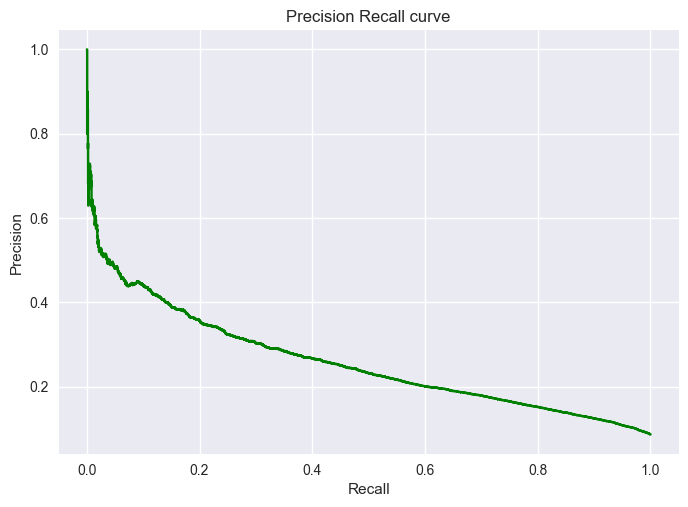

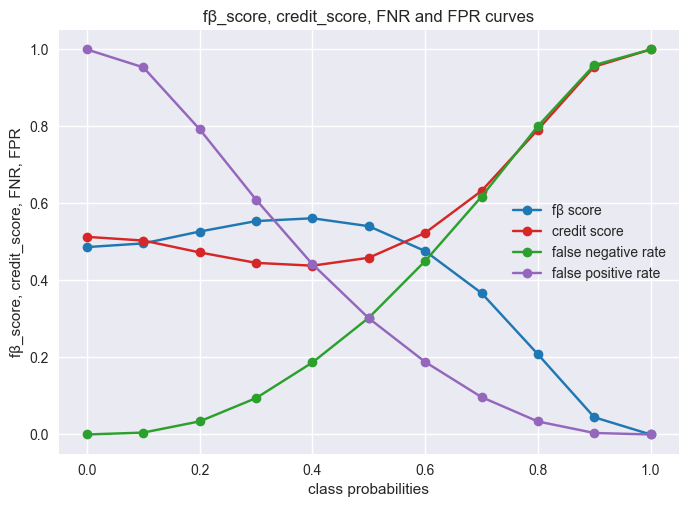

In [30]:
# 3.3 Results of applying the cost function and
# the evaluation metric to the algorithm of optimisation
scores_analysis(model, X_test, y_test, β)

## 4. L’interprétabilité globale et locale du modèle

L’interprétabilité d’un modèle permet de connaître les variables influentes afin de vérifier la cohérence des résultats de prédiction avec la connaissance réelle du métier et de contrôler le risque du modèle. En effet, le RGPD (article 22) prévoit des règles restrictives pour éviter que l’homme ne subisse des décisions émanant uniquement de machines. Étant donné que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit, il faut pouvoir expliquer à un client les raisons d’un refus afin de le conseiller.

### 4.1 L'interprétabilité globale du modèle

time: 1.93s


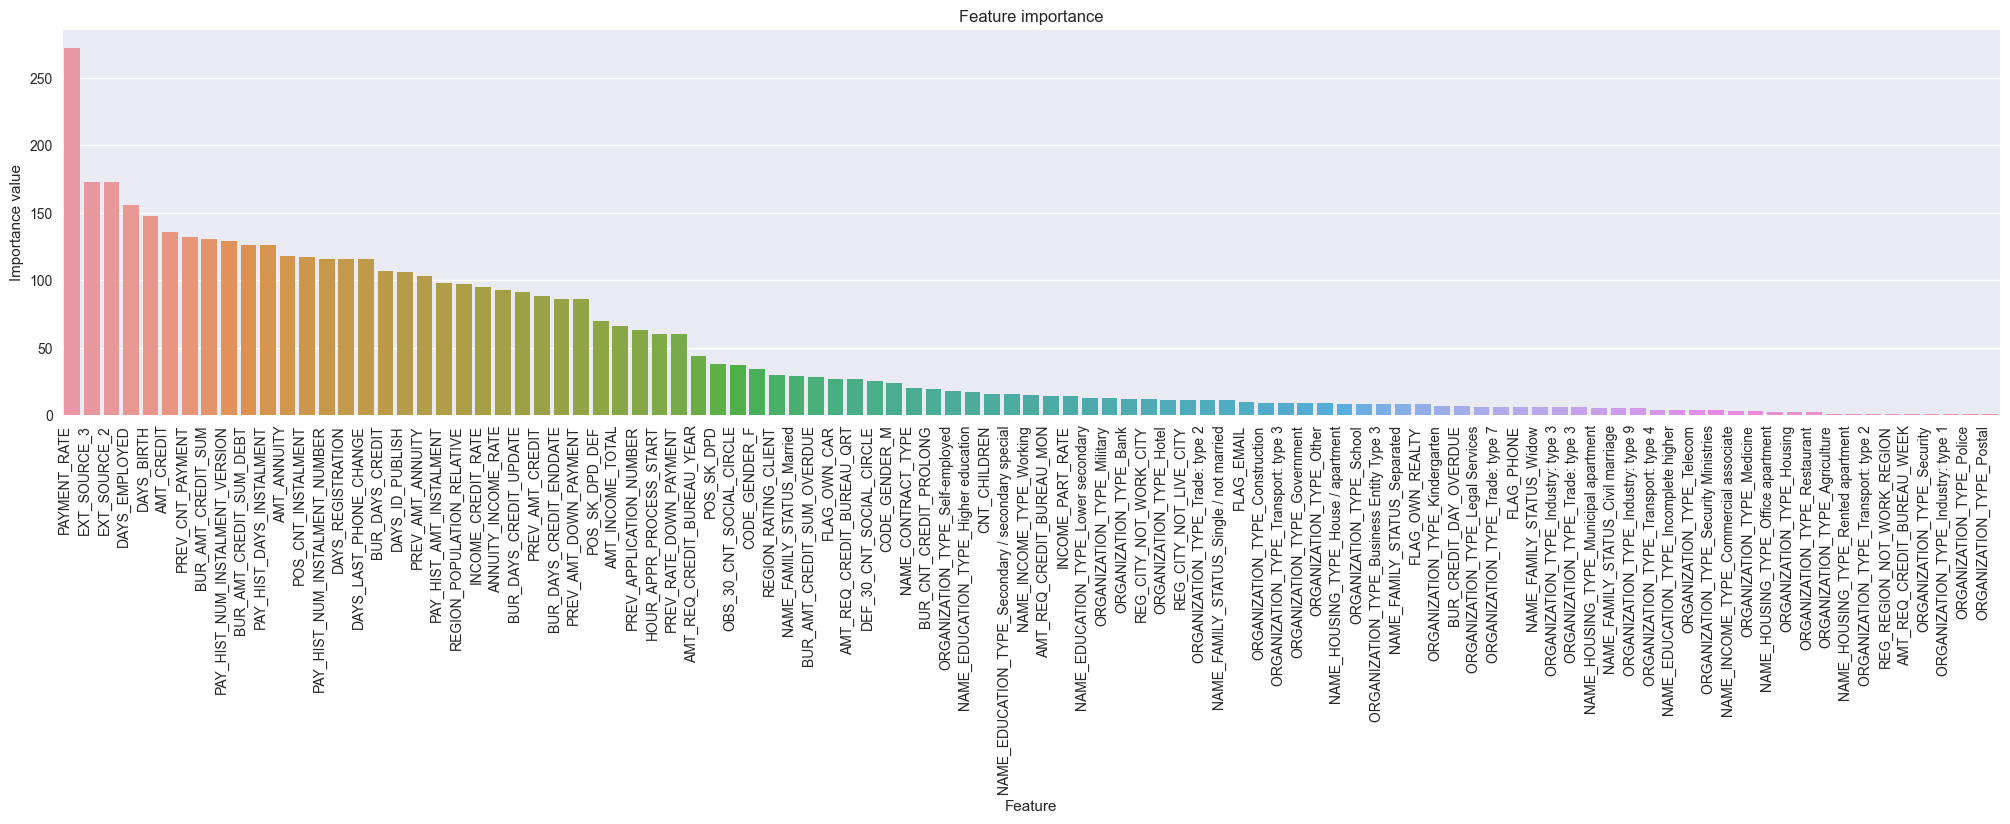

Number of relevant features: 141


In [31]:
# 4. Global and local interpretability of the model
# 4.1 Global interpretability of the model
# Feature importance
features = feature_engineering(X_train_res,
                               X_test,
                               y_train_res,
                               y_test,
                               model,
                               False,
                               True,
                               None,
                               credit_score)
print("Number of relevant features: {}".format(len(features)))

Le Feature importance permet de connaître de manière générale les variables importantes pour le modèle. L’importance des variables ne varie pas en fonction des données de chaque client.

### 4.2 L'interprétabilité locale du modèle

time: 1.98s


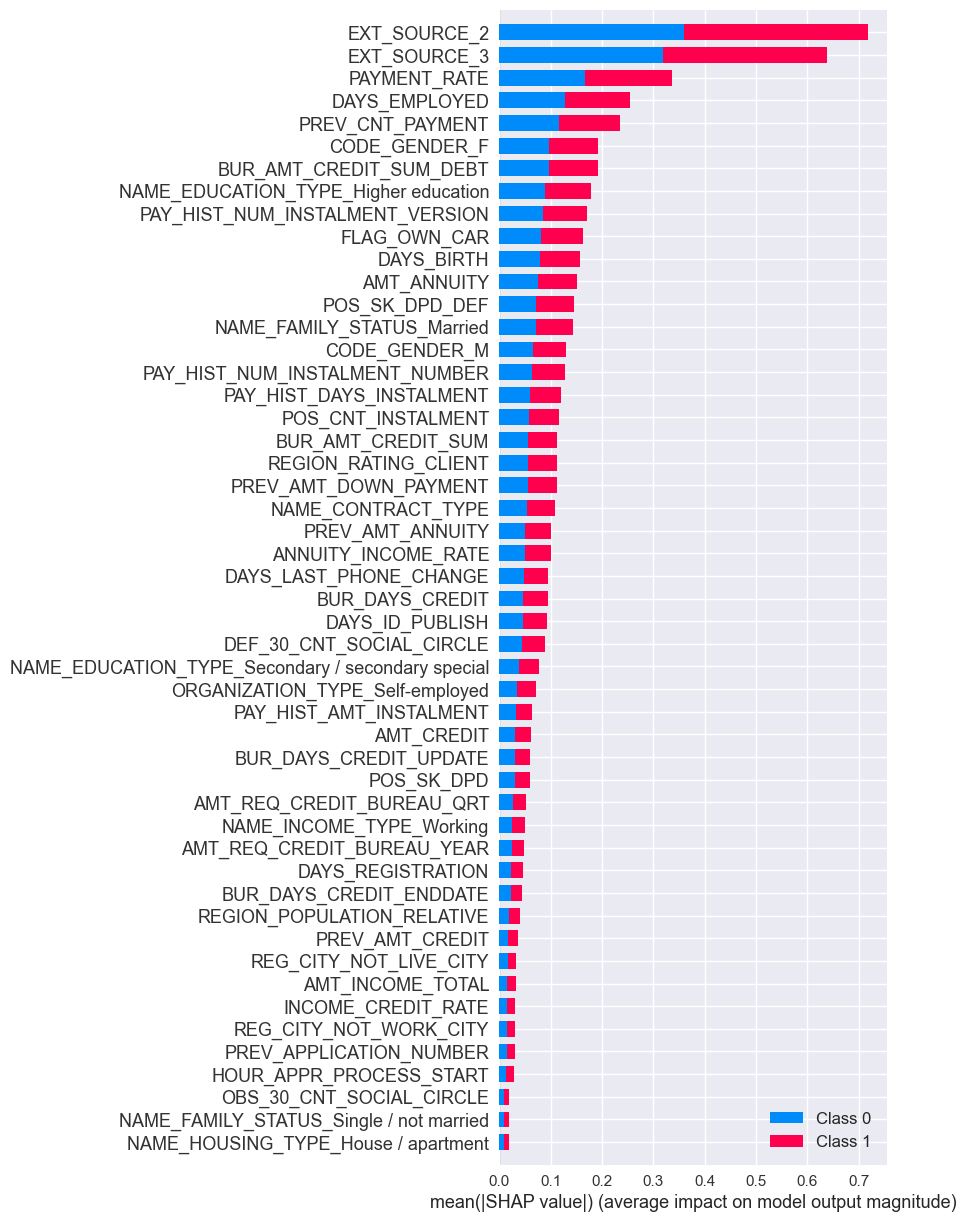

In [32]:
# 4.2 Local interpretability of the model
# SHAP explanations
feature_engineering(X_train_res,
                    X_test,
                    y_train_res,
                    y_test,
                    model,
                    False,
                    False,
                    50,
                    credit_score)

SHAP répond aux exigences du RGPD et permet de déterminer les effets des différentes variables dans le résultat de la prédiction. L’importance des variables varie en fonction des données de chaque client.

## 5. Sérialisation des modèles

### 5.1 Sérialisation de l'algorithme d'optimisation

Sérialiser le modèle à l'aide de pickle.

In [33]:
# 5. Serialisation of models
# 5.1 Serialising the algorithm of the optimisation
pickle.dump({'model': model}, open('model' + ".pkl", "wb"))

### 5.2 Sérialisation des transformations (imputations, normalisation et standardisation)

In [34]:
# 5.2 Serialisation of transformations
# (imputations, normalisation, and standardisation)
# Serialising the numerical imputer
pickle.dump({'num_imputer': num_imputer}, open('num_imputer' + ".pkl", "wb"))

In [35]:
# Serialising the binary imputer
pickle.dump({'bin_imputer': bin_imputer}, open('bin_imputer' + ".pkl", "wb"))

In [36]:
# Serialising the transformer
pickle.dump({'transformer': transformer}, open('transformer' + ".pkl", "wb"))

In [37]:
# Serialising the scaler
pickle.dump({'scaler': scaler}, open('scaler' + ".pkl", "wb"))

## 6. Conclusion

- Le nombre de faux positifs est élevé ;
- Il n’est pas possible d’avoir à la fois un bon rappel et une bonne précision ;
- Pour mieux choisir la valeur de bêta, il faut bien connaître le secteur d’activité et les attentes de l’entreprise ;
- L’application de l’article 22 du RGPD permet de contrôler le risque du modèle ;
- Pour s’assurer que le modèle est toujours en phase avec la réalité, il faut :
  - Mettre en place un système de monitoring de la performance ;
  - Réentraîner le modèle avec plus de données.